<a href="https://colab.research.google.com/github/CIMBIBOY/FungiCLEF2024_ADC/blob/main/caformer_continue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import time

import torchvision
import torch.nn.functional as F
import torch
from torch import nn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Subset
from torch.utils.data import DataLoader

import timm
import seaborn as sns
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def process(img, crop_s = 16, interp_mode = "bilinear", out_size = [300, 225]):
    img = img.transpose(1, 0, 2)
    # print(f"Input shape: {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        # Crop
        cropped_img = crop(img, crop_s)

        # Interpolation
        scale_factor = 300 / cropped_img.shape[0]
        sigma = scale_factor * 0.5
        cropped_img = interpolate(cropped_img, 5, sigma, int_mode = interp_mode, size = out_size)
        cropped_img = cropped_img.transpose(1, 2, 0)

        # Retransform
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        cropped_img = cropped_img.transpose(1, 0, 2)

        # Adding to array for saving as .npy
        # print(f"Output shape: {cropped_img.shape}")
        return np.array(cropped_img)

def crop(img, crop_s = 16):
    w, h, c = img.shape

    # Crop x pixels from the top and bottom
    if h > 270:
        img = img[:, crop_s:h - crop_s, :]
    #print(img.shape)
    return img

def interpolate(img, kernel_size = 5, sigma = 0.1, int_mode = "bilinear", size = [300, 225]):
    img = torch.tensor(img)
    # Blur for noise reduc
    blur = torchvision.transforms.GaussianBlur(kernel_size, sigma)
    blured_img = blur(img)
    blured_img = blured_img.transpose(0, 2)
    blured_img = blured_img.transpose(1, 2)
    # print(blured_img.shape)
    interpolated_img = F.interpolate(blured_img.unsqueeze(0), size, mode= int_mode)
    interpolated_img = interpolated_img.squeeze(0)
    # print(interpolated_img.shape)
    return interpolated_img.detach().numpy()

def downsample(data):
    d1 = cv2.pyrDown(data)
    d2 = cv2.pyrDown(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)

def upsample(data):
    d1 = cv2.pyrUp(data)
    d2 = cv2.pyrUp(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)


def fungi_collate_fn(batch):
    images, class_ids, toxicities, img_names = [], [], [], []
    for image, (class_id, toxicity), img_name in batch:
        # print(f"Individual image shape: {image.shape}")  # Should be [C, H, W]
        images.append(image)
        class_ids.append(class_id)
        toxicities.append(toxicity)
        img_names.append(img_name)

    images = torch.stack(images)  # Should result in shape [batch_size, C, H, W]
    #print(f"Batch images shape after stacking: {images.shape}")

    class_ids = torch.tensor(class_ids, dtype=torch.long)
    toxicities = torch.tensor(toxicities, dtype=torch.long)

    return images, (class_ids, toxicities), img_names

In [4]:
class FungiDataset(Dataset):
    def __init__(self, image_dir, labels_path, pre_load=True, crop_height=16, interpolate="bilinear", out_size=(300, 225), transform=None, class_ids_to_include=None):
        '''
        Args:
            image_dir: directory containing the images
            labels_path: path to the labels CSV file
            pre_load: True if images should be loaded into memory, False otherwise
            crop_height: Height for cropping images
            interpolate: Interpolation method
            out_size: Output size for resized images
            transform: Optional transform to be applied on a sample.
        '''
        self.image_dir = image_dir
        self.labels_path = labels_path
        self.pre_load = pre_load
        self.crop_h = crop_height
        self.interpolate = interpolate
        self.out_size = out_size
        self.transform = transform
        self.load_num = 0

        # Load metadata
        metadata = pd.read_csv(self.labels_path)

        # Filter to include only existing imgs
        image_files = set(os.listdir(self.image_dir))
        metadata = metadata[metadata['image_path'].isin(image_files)]

        if metadata.empty:
            raise ValueError('No matching images found in the image directory')

        # **Filter to include only specified class IDs**
        if class_ids_to_include is not None:
            metadata = metadata[metadata['class_id'].isin(class_ids_to_include)]
            metadata.reset_index(drop=True, inplace=True)

        # Reset index after filtering
        metadata.reset_index(drop=True, inplace=True)

        # Ensure labels are integers
        metadata['class_id'] = metadata['class_id'].astype(int)
        metadata['poisonous'] = metadata['poisonous'].astype(int)

        # **Remap class IDs to a continuous range starting from 0**
        unique_class_ids = sorted(metadata['class_id'].unique())
        class_id_to_idx = {original_id: idx for idx, original_id in enumerate(unique_class_ids)}
        metadata['class_id'] = metadata['class_id'].map(class_id_to_idx)

        # Update class IDs and calculate the number of species classes
        self.metadata = metadata
        self.image_paths = metadata['image_path'].tolist()
        self.class_ids = metadata['class_id'].tolist()
        self.toxicities = metadata['poisonous'].tolist()
        self.num_species_classes = len(unique_class_ids)

        # Pre-load images if required
        if self.pre_load:
            self.images = []
            for img_name in self.image_paths:
                img_path = os.path.join(self.image_dir, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Image {img_path} could not be read.")
                    continue

                img_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)
                # Convert image to tensor and float32
                image = torch.from_numpy(img_processed).float()
                image = image.permute(2, 0, 1)

                # Normalize using ImageNet mean and std
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                image = (image - mean) / std
                self.images.append(image)
                self.load_num += 1
                if self.load_num / 3 == 0:
                  print(f"{self.load_num / 1000} images loaded")
        else:
            self.images = None  # Images will be loaded in __getitem__

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.pre_load:
            image = self.images[idx]
        else:
            img_name = self.image_paths[idx]
            img_path = os.path.join(self.image_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image at {img_path} could not be read.")

            image_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)

            # Convert image to tensor and float32
            img_tensor = torch.from_numpy(image_processed).float().permute(2, 0, 1)

            # Normalize using ImageNet mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = (img_tensor - mean) / std

            '''
            print(image.shape)
            print(f"Image dtype: {image.dtype}")  # Should be torch.float32
            print(f"Image min: {image.min()}, max: {image.max()}")  # Should be within expected range
            '''

        # labels
        class_id = self.class_ids[idx]
        toxicity = self.toxicities[idx]

        return image, (class_id, toxicity), img_name


In [16]:
# Configuration
config = {
    "image_dir": "/content/drive/MyDrive/Tree_trunk/Fungi/x_train",
    "labels_path": "/content/drive/MyDrive/Tree_trunk/Fungi/train_metadata_height.csv",
    "pre_load": False,
    "batch_size": 128,
    "crop_height": 16,
    "interpolate": "bilinear",
    "out_size": (224, 224)
}

# Define the classes to include (your list of unique class IDs)
class_ids_to_include = [4, 11, 16, 25, 30, 32, 37, 39, 43, 63, 100, 103, 128, 129, 131, 136, 142, 168, 180, 213, 214, 223, 252, 266, 309, 366, 389, 413, 473, 478, 487, 522, 555, 559, 591, 633, 637, 657, 671, 673, 689, 694, 724, 728, 738, 748, 764, 787, 812, 814, 830, 837, 845, 856, 884, 908, 909, 912, 967, 975, 989, 992, 1000, 1005, 1014, 1020, 1052, 1054, 1088, 1093, 1115, 1121, 1135, 1136, 1141, 1160, 1183, 1207, 1214, 1220, 1221, 1232, 1239, 1242, 1290, 1302, 1355, 1381, 1395, 1420, 1438, 1440, 1481, 1484, 1493, 1533, 1537, 1546, 1573, 1603]

# Initialize the full dataset
full_dataset = FungiDataset(
    image_dir=config["image_dir"],
    labels_path=config["labels_path"],
    pre_load=config["pre_load"],
    crop_height=config["crop_height"],
    interpolate=config["interpolate"],
    out_size=config["out_size"],
    transform=None,
    class_ids_to_include=class_ids_to_include  # Pass the list of class IDs
)

print(f"Number of samples in dataset: {len(full_dataset)}")

# Split into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=1,
    prefetch_factor=1,  # Prefetch batches to improve performance
    pin_memory=True,  # Optimize for GPU
    collate_fn=fungi_collate_fn,
    drop_last=True  # Drops the last incomplete batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=1,
    prefetch_factor=1,
    pin_memory=True,
    collate_fn=fungi_collate_fn,
    drop_last=True # also
)

print(f"Length of train_loader: {len(train_loader)} and val_loader: {len(val_loader)}")

Number of samples in dataset: 25763
Length of train_loader: 161 and val_loader: 40


In [17]:
import torch.optim as optim

# Set num_species_classes based on the dataset
num_species_classes = full_dataset.num_species_classes
print(f"Number of species classes: {num_species_classes}")  # Should print 100
num_toxicity_classes = 2   # Assuming binary classification (edible or poisonous)

# Create the CAFormer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = timm.create_model(
    "caformer_s18.sail_in22k",
    pretrained=True,
    num_classes=num_species_classes  # For species classification
)
base_model.to(device)

class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_species_classes, num_toxicity_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model

        # Replace the classifier for species classification
        self.base_model.reset_classifier(num_species_classes)

        num_features = base_model.num_features  # Number of features after pooling

        # Create a new classifier for toxicity
        self.fc_toxicity = nn.Linear(num_features, num_toxicity_classes)

        # Define a pooling layer if not present
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Extract features
        features = self.base_model.forward_features(x)  # Shape: [batch_size, channels, height, width]
        # print(f"Features shape: {features.shape}")

        # Species classification (using base model's head)
        species_logits = self.base_model.forward_head(features)
        # print(f"Species logits shape: {species_logits.shape}")

        # Apply global average pooling for toxicity classification
        pooled_features = self.global_pool(features).flatten(1)  # Shape: [batch_size, channels]
        # print(f"Pooled features shape: {pooled_features.shape}")

        # Toxicity classification
        toxicity_logits = self.fc_toxicity(pooled_features)
        # print(f"Toxicity logits shape: {toxicity_logits.shape}")

        return {'species': species_logits, 'toxicity': toxicity_logits}

# Initialize the multi-task model
model = MultiTaskModel(base_model, num_species_classes, num_toxicity_classes)
model.to(device)

# Load pretrained weights
pretrained_weights_path = "/content/multi_task_model.pth"  # Path to your saved weights
try:
    state_dict = torch.load(pretrained_weights_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    print("Pretrained weights loaded successfully.")
except FileNotFoundError:
    print(f"Pretrained weights file not found: {pretrained_weights_path}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate as needed

# Define loss functions
criterion_species = nn.CrossEntropyLoss()
criterion_toxicity = nn.CrossEntropyLoss()

print(model)

Number of species classes: 100
Pretrained weights loaded successfully.
MultiTaskModel(
  (base_model): MetaFormer(
    (stem): Stem(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (norm): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): MetaFormerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): MetaFormerBlock(
            (norm1): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
            (token_mixer): SepConv(
              (pwconv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (act1): StarReLU(
                (relu): ReLU()
              )
              (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128, bias=False)
              (act2): Identity()
              (pwconv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (drop_path

In [7]:
# Get a batch of data
images, (class_ids, toxicities), _ = next(iter(train_loader))

# Check the range of class_ids
print(f"Class IDs in batch: {class_ids}")
print(f"Min class ID: {class_ids.min()}, Max class ID: {class_ids.max()}")

# Ensure class IDs are in the range [0, num_species_classes - 1]
assert class_ids.min() >= 0 and class_ids.max() < num_species_classes

Class IDs in batch: tensor([13, 19, 80, 70,  5, 19, 12, 33, 34, 59, 77,  7, 77, 69, 99, 39, 32, 27,
        62, 32, 60, 48, 26, 74, 83, 59, 37, 32, 13, 77, 69,  5, 51, 15, 29, 78,
        93, 56, 85, 28, 91, 92, 31, 88, 81, 87, 48, 32, 54,  6, 39,  5, 26, 17,
        22, 48,  5,  4, 83, 70, 28, 18, 46, 17, 18, 54, 20, 54,  2, 17, 65, 81,
        23,  6, 98, 78, 23, 89, 77, 32, 11,  1, 25, 68,  7, 93, 99, 86, 13, 70,
        14,  9, 90, 59, 14, 64, 77, 94,  5, 38, 31, 67, 11, 43, 87, 25, 92, 76,
        62, 61, 48, 52, 19, 56, 50, 27, 38, 84, 87, 29, 64, 46, 18, 80, 67,  2,
        74, 77])
Min class ID: 1, Max class ID: 99


In [18]:
def conf_matrix(targets, predictions, task_name, matrix_type='species', colors=None):
    """
    Compute and plot a confusion matrix with customizable display and colors.

    Args:
        targets: True labels.
        predictions: Predicted labels.
        task_name: Name of the task (e.g., 'Species', 'Toxicity').
        matrix_type: Type of matrix ('species' or 'toxicity') for specific display logic.
        colors: Custom color palette.
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import numpy as np

    # Compute confusion matrix
    cm = confusion_matrix(targets, predictions)

    if matrix_type == 'species':
        # For Species Misclassification Matrix
        plt.figure(figsize=(6, 1))  # Wide and short, single row
        sns.set(font_scale=1.4)

        # Define colors: Red for misclassified, Green for recognized
        cmap = sns.color_palette(['green', 'red']) if not colors else sns.color_palette(colors)

        sns.heatmap(
            cm[:1],  # Only show the first row
            annot=True,
            fmt='d',
            cmap=cmap,
            cbar=False,
            xticklabels=['Missclassified', 'Recognized'],  # Bottom labels
            yticklabels=[]  # Remove true labels from the side
        )
        plt.xlabel('Predicted')
        plt.title(f'{task_name} Misclassification Matrix')
        plt.show()

    if matrix_type == 'toxicity':
        # For Toxicity Matrix
        plt.figure(figsize=(6, 5))
        sns.set(font_scale=1.4)

        # Assign unique indices to each cell type
        cell_type_indices = np.array([[0, 1], [2, 3]])  # TN, FP, FN, TP

        # Define custom colors for each cell type
        if colors is None:
            colors = ['black', 'yellow', 'purple', 'black']  # TN, FP, FN, TP

        # Create a custom colormap from the specified colors
        custom_cmap = ListedColormap(colors)

        # Plot the heatmap using the cell_type_indices to map colors
        sns.heatmap(
            cell_type_indices,
            annot=cm,
            fmt='d',
            cmap=custom_cmap,
            cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{task_name} Classification Confusion Matrix')
        plt.show()

    return cm

In [36]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, alpha = 1.0, beta = 0.6):
    train_losses = []
    val_losses = []
    train_accuracies_species = []
    train_accuracies_toxicity = []
    val_accuracies_species = []
    val_accuracies_toxicity = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        correct_species = 0
        correct_toxicity = 0
        total_samples = 0

        # Iterate over batches
        for batch_idx, (images, (class_ids, toxicities), _) in enumerate(train_loader):
            images = images.to(device)
            class_ids = class_ids.to(device, dtype=torch.long)
            toxicities = toxicities.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)

            loss_species = criterion_species(outputs['species'], class_ids)
            loss_toxicity = criterion_toxicity(outputs['toxicity'], toxicities)
            loss = alpha * loss_species + beta * loss_toxicity  # weighting

            loss.backward()
            optimizer.step()

            # Update running loss
            batch_loss = loss.item() * images.size(0)
            running_loss += batch_loss

            # Calculate accuracies
            _, preds_species = torch.max(outputs['species'], 1)
            _, preds_toxicity = torch.max(outputs['toxicity'], 1)
            batch_correct_species = (preds_species == class_ids).sum().item()
            batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
            batch_samples = images.size(0)
            correct_species += batch_correct_species
            correct_toxicity += batch_correct_toxicity
            total_samples += batch_samples

            # Calculate batch accuracies
            batch_accuracy_species = batch_correct_species / batch_samples * 100
            batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100

            # Print per-batch metrics
            print(f"Train Batch {batch_idx+1}/{len(train_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")

        avg_train_loss = running_loss / total_samples
        train_losses.append(avg_train_loss)
        train_accuracy_species = correct_species / total_samples * 100
        train_accuracy_toxicity = correct_toxicity / total_samples * 100
        train_accuracies_species.append(train_accuracy_species)
        train_accuracies_toxicity.append(train_accuracy_toxicity)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct_species = 0
        val_correct_toxicity = 0
        val_total_samples = 0
        val_predictions_species = []
        val_targets_species = []
        val_predictions_toxicity = []
        val_targets_toxicity = []

        with torch.no_grad():
            for batch_idx, (images, (class_ids, toxicities), _) in enumerate(val_loader):
                images = images.to(device)
                class_ids = class_ids.to(device, dtype=torch.long)
                toxicities = toxicities.to(device, dtype=torch.long)

                outputs = model(images)

                loss_species = criterion_species(outputs['species'], class_ids)
                loss_toxicity = criterion_toxicity(outputs['toxicity'], toxicities)
                loss = alpha * loss_species + beta * loss_toxicity  # Adjust weighting

                # Update running loss
                batch_loss = loss.item() * images.size(0)
                val_running_loss += batch_loss

                # Calculate accuracies
                _, preds_species = torch.max(outputs['species'], 1)
                _, preds_toxicity = torch.max(outputs['toxicity'], 1)
                batch_correct_species = (preds_species == class_ids).sum().item()
                batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
                batch_samples = images.size(0)
                val_correct_species += batch_correct_species
                val_correct_toxicity += batch_correct_toxicity
                val_total_samples += batch_samples

                # Store predictions and targets for confusion matrices
                val_predictions_species.extend(preds_species.cpu().numpy())
                val_targets_species.extend(class_ids.cpu().numpy())
                val_predictions_toxicity.extend(preds_toxicity.cpu().numpy())
                val_targets_toxicity.extend(toxicities.cpu().numpy())

                # Calculate batch accuracies
                batch_accuracy_species = batch_correct_species / batch_samples * 100
                batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100

                # Print per-batch metrics
                print(f"Val Batch {batch_idx+1}/{len(val_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")

        avg_val_loss = val_running_loss / val_total_samples
        val_losses.append(avg_val_loss)
        val_accuracy_species = val_correct_species / val_total_samples * 100
        val_accuracy_toxicity = val_correct_toxicity / val_total_samples * 100
        val_accuracies_species.append(val_accuracy_species)
        val_accuracies_toxicity.append(val_accuracy_toxicity)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Species Acc: {train_accuracy_species:.2f}%, Toxicity Acc: {train_accuracy_toxicity:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f}, Species Acc: {val_accuracy_species:.2f}%, Toxicity Acc: {val_accuracy_toxicity:.2f}%")

        # Confusion Matrices
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        # For Species Classification
        val_predictions_species = np.array(val_predictions_species)
        val_targets_species = np.array(val_targets_species)

        # Compute the confusion matrix for species classification
        species_conf_matrix = confusion_matrix(val_targets_species, val_predictions_species)

        plt.figure(figsize=(10, 8))
        plt.imshow(species_conf_matrix, cmap="viridis")
        plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfúziós mátrix mérgezőségre")
        plt.axis('off')
        plt.show()

        # For Toxicity Classification
        val_predictions_toxicity = np.array(val_predictions_toxicity)
        val_targets_toxicity = np.array(val_targets_toxicity)

        # Compute the confusion matrix for toxicity classification
        toxicity_conf_matrix = confusion_matrix(val_targets_toxicity, val_predictions_toxicity)

        plt.figure(figsize=(10, 8))
        plt.imshow(toxicity_conf_matrix, cmap="viridis")
        plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfúziós mátrix mérgezőségre")
        plt.axis('off')
        plt.show()

        '''
        # Plot Confusion Matrix for Species Classification
        conf_matrix(
            species_binary_targets,
            species_binary_predictions,
            task_name='Species',
            matrix_type='species',
            colors=['red', 'green']  # Red for misclassified, Green for recognized
        )
        '''
        '''
        # Plot Confusion Matrix for Toxicity Classification
        conf_matrix(
            toxicity_targets,
            toxicity_predictions,
            task_name='Toxicity',
            matrix_type='toxicity',
            colors=['orange', 'yellow', 'purple', 'black']  # TN, FP, FN, TP
        )
        '''

        from sklearn.metrics import classification_report

        classification_report_species = classification_report(val_targets_species, val_predictions_species)
        classification_report_toxicity = classification_report(val_targets_toxicity, val_predictions_toxicity)
        print(f"Species Classification Report:\n{classification_report_species}")
        print(f"Toxicity Classification Report:\n{classification_report_toxicity}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies_species': train_accuracies_species,
        'train_accuracies_toxicity': train_accuracies_toxicity,
        'val_accuracies_species': val_accuracies_species,
        'val_accuracies_toxicity': val_accuracies_toxicity
    }

In [25]:
# Set the number of epochs
num_epochs = 1

In [21]:
'''
# Clear CUDA cache
torch.cuda.empty_cache()

# Check memory usage (optional)
torch.cuda.memory_summary(device=None, abbreviated=False)
#'''

'\n# Clear CUDA cache\ntorch.cuda.empty_cache()\n\n# Check memory usage (optional)\ntorch.cuda.memory_summary(device=None, abbreviated=False)\n#'


Epoch 1/1
Train Batch 1/161: Loss = 0.0189, Species Acc = 99.22%, Toxicity Acc = 100.00%
Train Batch 2/161: Loss = 0.0181, Species Acc = 99.22%, Toxicity Acc = 100.00%
Train Batch 3/161: Loss = 0.0040, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 4/161: Loss = 0.0812, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 5/161: Loss = 0.0022, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 6/161: Loss = 0.0061, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 7/161: Loss = 0.0011, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 8/161: Loss = 0.0060, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 9/161: Loss = 0.0011, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 10/161: Loss = 0.0102, Species Acc = 99.22%, Toxicity Acc = 100.00%
Train Batch 11/161: Loss = 0.0134, Species Acc = 99.22%, Toxicity Acc = 100.00%
Train Batch 12/161: Loss = 0.0117, Species Acc = 99.22%, Toxicity Acc = 100.00%
Train Batch 13/161: Loss = 0.008

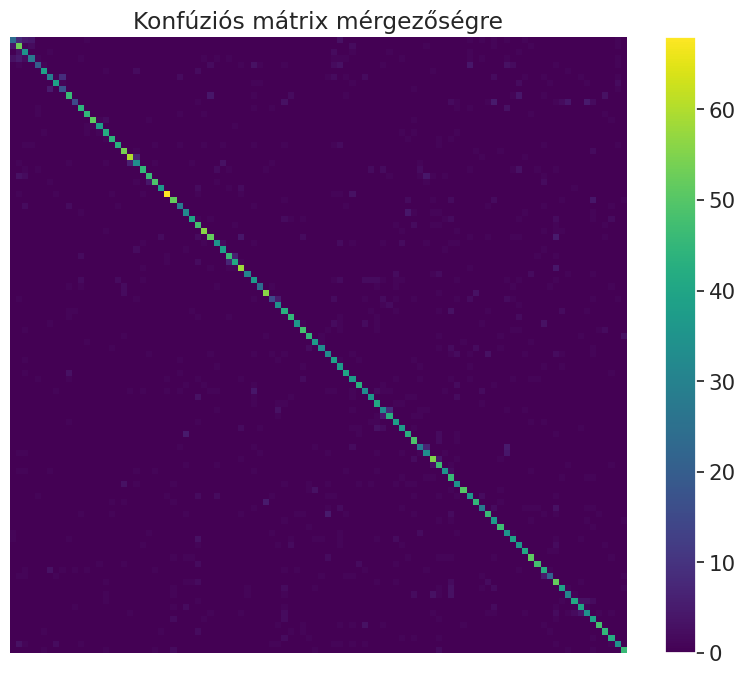

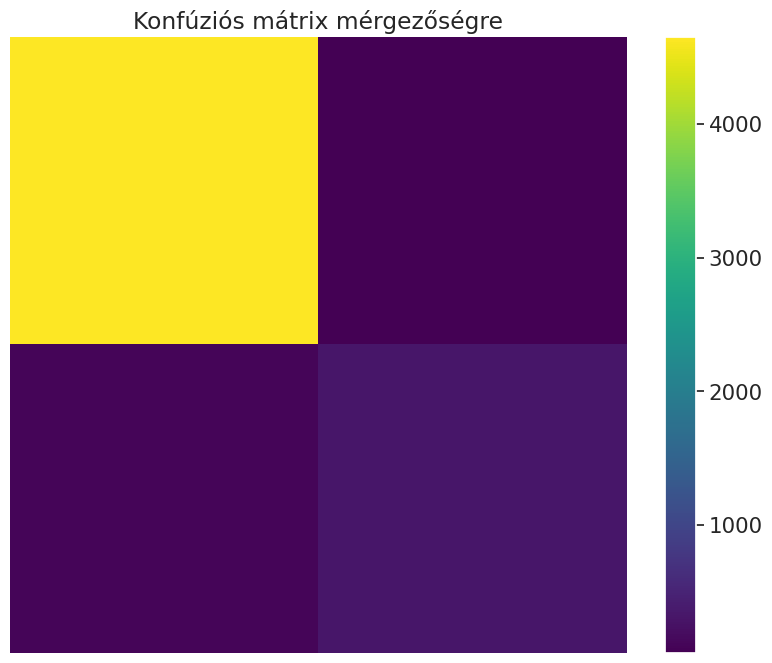

Species Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57        51
           1       0.65      0.80      0.72        66
           2       0.61      0.78      0.69        45
           3       0.79      0.54      0.64        50
           4       0.77      0.43      0.55        47
           5       0.91      0.85      0.88        46
           6       0.71      0.55      0.62        53
           7       0.87      0.80      0.83        49
           8       0.61      0.71      0.65        24
           9       0.79      0.73      0.76        63
          10       0.83      0.36      0.50        42
          11       0.83      0.85      0.84        52
          12       0.90      0.90      0.90        50
          13       0.98      0.89      0.94        57
          14       0.93      0.93      0.93        41
          15       0.81      0.88      0.84        48
          16       0.92      0.92      0.92       

In [38]:
# Start training
training_stats = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model and statistics
torch.save(model.state_dict(), "multi_task_model2.pth")
print("Training completed!")

In [41]:
from tabulate import tabulate
!pip install colorama
from colorama import Fore, Style

# Predefined values from the screenshot
epoch = 51
num_epochs = 51
train_loss = 0.0109
train_species_acc = 99.67
train_toxicity_acc = 100.00
val_loss = 1.3235
val_species_acc = 78.28
val_toxicity_acc = 97.01

# Prepare the table data
data = [
    ["Train Loss", f"{Fore.GREEN}{train_loss:.4f}{Style.RESET_ALL}"],
    ["Train Species Accuracy", f"{Fore.GREEN}{train_species_acc:.2f}%{Style.RESET_ALL}"],
    ["Train Toxicity Accuracy", f"{Fore.GREEN}{train_toxicity_acc:.2f}%{Style.RESET_ALL}"],
    ["Validation Loss", f"{Fore.YELLOW}{val_loss:.4f}{Style.RESET_ALL}"],
    ["Validation Species Accuracy", f"{Fore.YELLOW}{val_species_acc:.2f}%{Style.RESET_ALL}"],
    ["Validation Toxicity Accuracy", f"{Fore.YELLOW}{val_toxicity_acc:.2f}%{Style.RESET_ALL}"],
]

# Print the epoch summary
print(f"\n{Fore.CYAN}Epoch {epoch}/{num_epochs} Summary:{Style.RESET_ALL}")
print(tabulate(data, headers=["Metric", "Value"], tablefmt="fancy_grid"))


Epoch 51/51 Summary:
╒══════════════════════════════╤═════════╕
│ Metric                       │ Value   │
╞══════════════════════════════╪═════════╡
│ Train Loss                   │ 0.0109  │
├──────────────────────────────┼─────────┤
│ Train Species Accuracy       │ 99.67%  │
├──────────────────────────────┼─────────┤
│ Train Toxicity Accuracy      │ 100.00% │
├──────────────────────────────┼─────────┤
│ Validation Loss              │ 1.3235  │
├──────────────────────────────┼─────────┤
│ Validation Species Accuracy  │ 78.28%  │
├──────────────────────────────┼─────────┤
│ Validation Toxicity Accuracy │ 97.01%  │
╘══════════════════════════════╧═════════╛
